# Augmented Model Architecture Analysis

This notebook analyzes the performance of our augmented fiber orientation prediction model across different scenarios:

1. Raw vs Augmented Data Performance
2. Cross-Domain Generalization
3. Feature Space Analysis
4. Model Robustness Study

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import pickle

# Add src directory to Python path for imports
sys.path.append(os.path.abspath('../../src'))

# Import from our package
from fiber_predictor.svr_hog.data_processing import HogDataset, balance_dataset
from fiber_predictor.svr_hog.models import FiberPredictor

IMAGE_DIR = '../../images'
MODEL_DIR = '../../models'

## 1. Data Loading and Processing

In [3]:
# HOG parameters
grid_quotient = np.arange(1, 4)
orientations = 10

# Dataset paths
bio_file_dir = os.path.join(IMAGE_DIR, "bio/")
bio_csv_dir = os.path.join(IMAGE_DIR, "bio/labels.csv")
diff_file_dir = os.path.join(IMAGE_DIR, "diffusion/")
diff_csv_dir = os.path.join(IMAGE_DIR, "diffusion/labels.csv")

def load_and_process_data(file_dir, csv_dir, augment=False):
    """Load and process dataset with optional augmentation"""
    dataset = HogDataset(
        labels_path=csv_dir,
        file_dir=file_dir,
        grid_quotient=grid_quotient,
        orientations=orientations,
        augment_whole_dataset=augment
    )
    
    feature_matrix = []
    labels = []
    file_paths = []
    
    for idx in range(len(dataset)):
        file_path, features_tensor, angle = dataset[idx]
        feature_matrix.append(features_tensor.numpy())
        labels.append(angle)
        file_paths.append(file_path)
    
    return {
        'features': np.array(feature_matrix),
        'labels': np.array(labels),
        'file_paths': np.array(file_paths),
        'n_samples': len(labels),
        'n_features': feature_matrix[0].shape[0]
    }

# Load all datasets
print("Loading datasets...")
bio_raw = load_and_process_data(bio_file_dir, bio_csv_dir)
bio_aug = load_and_process_data(bio_file_dir, bio_csv_dir, augment=True)
diff_raw = load_and_process_data(diff_file_dir, diff_csv_dir)

# Print dataset information
print("\nDataset sizes:")
print(f"Raw Biological: {bio_raw['n_samples']} samples, {bio_raw['n_features']} features")
print(f"Augmented Biological: {bio_aug['n_samples']} samples, {bio_aug['n_features']} features")
print(f"Diffusion: {diff_raw['n_samples']} samples, {diff_raw['n_features']} features")

Loading datasets...

Dataset sizes:
Raw Biological: 673 samples, 140 features
Augmented Biological: 4711 samples, 140 features
Diffusion: 609 samples, 140 features


## 2. Data Distribution Analysis

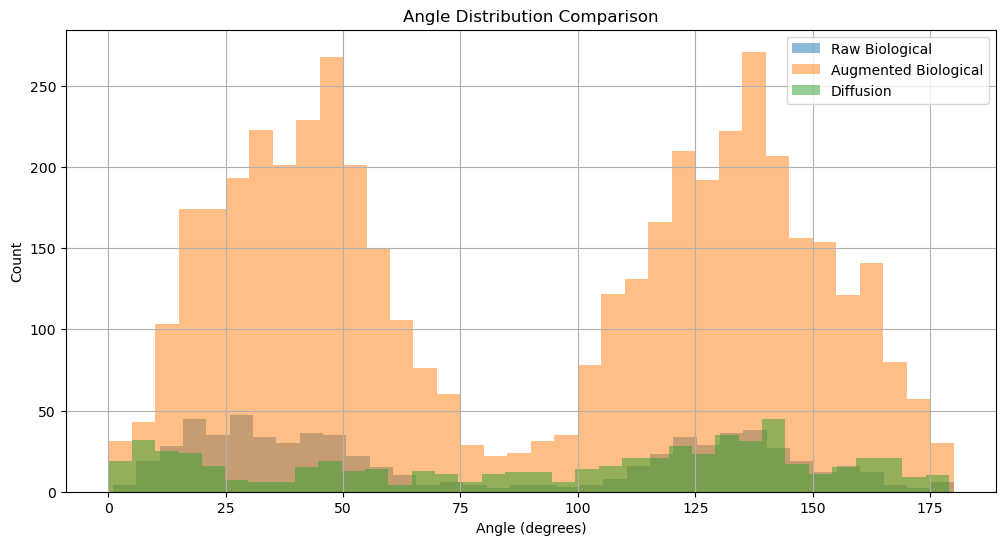

In [4]:
def plot_angle_distributions(datasets, names, bins=36):
    """Plot angle distributions for multiple datasets"""
    plt.figure(figsize=(12, 6))
    
    for data, name in zip(datasets, names):
        plt.hist(data['labels'], bins=bins, alpha=0.5, label=name)
    
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Count')
    plt.title('Angle Distribution Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot distributions
plot_angle_distributions(
    [bio_raw, bio_aug, diff_raw],
    ['Raw Biological', 'Augmented Biological', 'Diffusion']
)

## 3. Model Training and Evaluation

In [5]:
def train_evaluate_model(X_train, y_train, test_sets, model_name=None):
    """Train model and evaluate on multiple test sets"""
    # Split training data
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.3, random_state=42
    )
    
    # Initialize and train model
    model = FiberPredictor(
        scaler_type="Standard",
        pca_params={"n_components": 0.95},
        regressor_type="SVR",
        regressor_params={"kernel": "rbf", "C": 100, "gamma": 0.01}
    )
    model.fit(X_train_split, y_train_split)
    
    # Evaluate
    results = {
        'model_name': model_name,
        'n_train': len(X_train_split),
        'n_val': len(X_val)
    }
    
    # Validation performance
    val_pred = model.predict(X_val)
    results['val_mae'] = mean_absolute_error(y_val, val_pred)
    results['val_r2'] = r2_score(y_val, val_pred)
    
    # Test set performance
    for name, (X_test, y_test) in test_sets.items():
        y_pred = model.predict(X_test)
        results[f'{name}_mae'] = mean_absolute_error(y_test, y_pred)
        results[f'{name}_r2'] = r2_score(y_test, y_pred)
        results[f'{name}_pred'] = y_pred
        results[f'{name}_true'] = y_test
    
    # Save model if name provided
    if model_name:
        with open(os.path.join(MODEL_DIR, f'svr_hog/{model_name}.pkl'), 'wb') as f:
            pickle.dump(model, f)
    
    return results

# Training scenarios
scenarios = [
    {
        'name': 'raw_bio',
        'train_features': bio_raw['features'],
        'train_labels': bio_raw['labels'],
        'test_sets': {
            'diffusion': (diff_raw['features'], diff_raw['labels'])
        }
    },
    {
        'name': 'aug_bio',
        'train_features': bio_aug['features'],
        'train_labels': bio_aug['labels'],
        'test_sets': {
            'raw_bio': (bio_raw['features'], bio_raw['labels']),
            'diffusion': (diff_raw['features'], diff_raw['labels'])
        }
    }
]

# Train and evaluate all scenarios
results = []
for scenario in scenarios:
    print(f"\nTraining {scenario['name']} model...")
    result = train_evaluate_model(
        scenario['train_features'],
        scenario['train_labels'],
        scenario['test_sets'],
        model_name=scenario['name']
    )
    results.append(result)

# Create summary DataFrame
summary_df = pd.DataFrame(results)
print("\nModel Performance Summary:")
display(summary_df)


Training raw_bio model...

Training aug_bio model...

Model Performance Summary:


,model_name,n_train,n_val,val_mae,val_r2,diffusion_mae,diffusion_r2,diffusion_pred,diffusion_true,raw_bio_mae,raw_bio_r2,raw_bio_pred,raw_bio_true
0,raw_bio,471,202,14.166508,0.727839,16.814022,0.752222,"[111.25825240095713, 117.29675775396669, 104.5...","[109, 138, 124, 138, 77, 153, 141, 135, 148, 1...",NaN,NaN,NaN,NaN
1,aug_bio,3297,1414,12.793093,0.772374,13.894518,0.808304,"[119.19010837375068, 116.56915475904103, 108.6...","[109, 138, 124, 138, 77, 153, 141, 135, 148, 1...",11.28931,0.80569,"[89.47200476936455, 55.33377727169194, 52.5319...","[47, 48, 59, 36, 58, 39, 58, 45, 43, 42, 49, 5..."


## 4. Performance Visualization

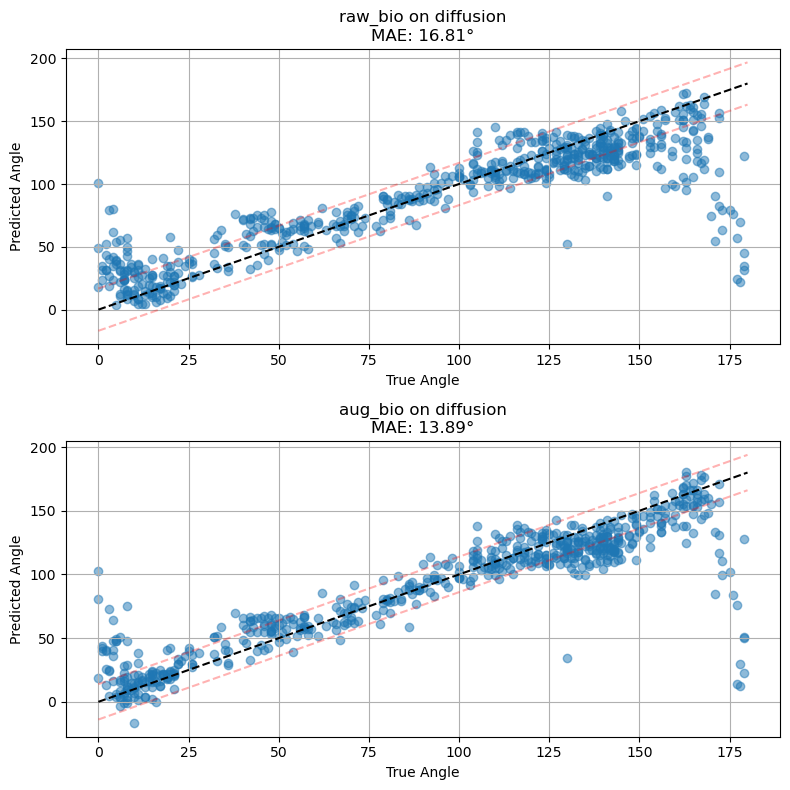

In [12]:
def plot_prediction_comparison(results):
    """Plot prediction vs true values for each test set"""
    n_models = len(results)
    test_sets = [key for key in results[0].keys() if key.endswith('_true')]
    n_sets = len(test_sets)
    
    fig, axes = plt.subplots(n_models, n_sets, figsize=(8*n_sets, 4*n_models))
    if n_models == 1:
        axes = [axes]
    
    for i, result in enumerate(results):
        for j, test_set in enumerate(test_sets):
            set_name = test_set[:-5]  # Remove '_true'
            true_vals = result[f'{set_name}_true']
            pred_vals = result[f'{set_name}_pred']
            mae = result[f'{set_name}_mae']
            
            ax = axes[i][j] if n_sets > 1 else axes[i]
            ax.scatter(true_vals, pred_vals, alpha=0.5)
            ax.plot([0, 180], [0, 180], 'k--')
            ax.set_xlabel('True Angle')
            ax.set_ylabel('Predicted Angle')
            ax.set_title(f'{result["model_name"]} on {set_name}\nMAE: {mae:.2f}°')
            ax.grid(True)
            
            # Plot error bounds
            ax.plot([0, 180], [mae, 180+mae], 'r--', alpha=0.3)
            ax.plot([0, 180], [-mae, 180-mae], 'r--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot predictions
plot_prediction_comparison(results)

## 5. Error Analysis

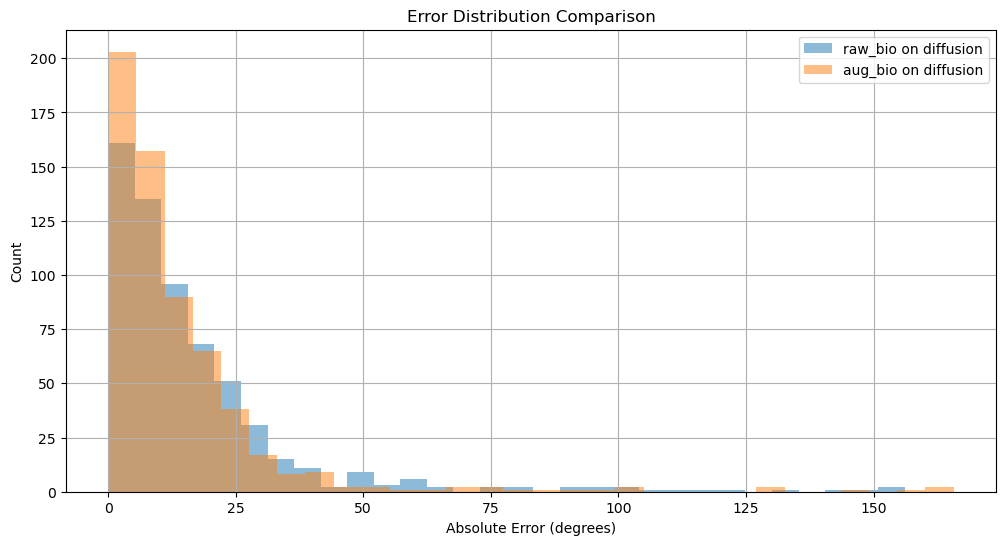

In [7]:
def plot_error_distribution(results):
    """Plot error distributions for each model and test set"""
    test_sets = [key for key in results[0].keys() if key.endswith('_true')]
    
    plt.figure(figsize=(12, 6))
    
    for result in results:
        for test_set in test_sets:
            set_name = test_set[:-5]  # Remove '_true'
            errors = np.abs(result[f'{set_name}_pred'] - result[f'{set_name}_true'])
            plt.hist(errors, bins=30, alpha=0.5, 
                    label=f'{result["model_name"]} on {set_name}')
    
    plt.xlabel('Absolute Error (degrees)')
    plt.ylabel('Count')
    plt.title('Error Distribution Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot error distributions
plot_error_distribution(results)

## 6. Performance vs Angle Analysis

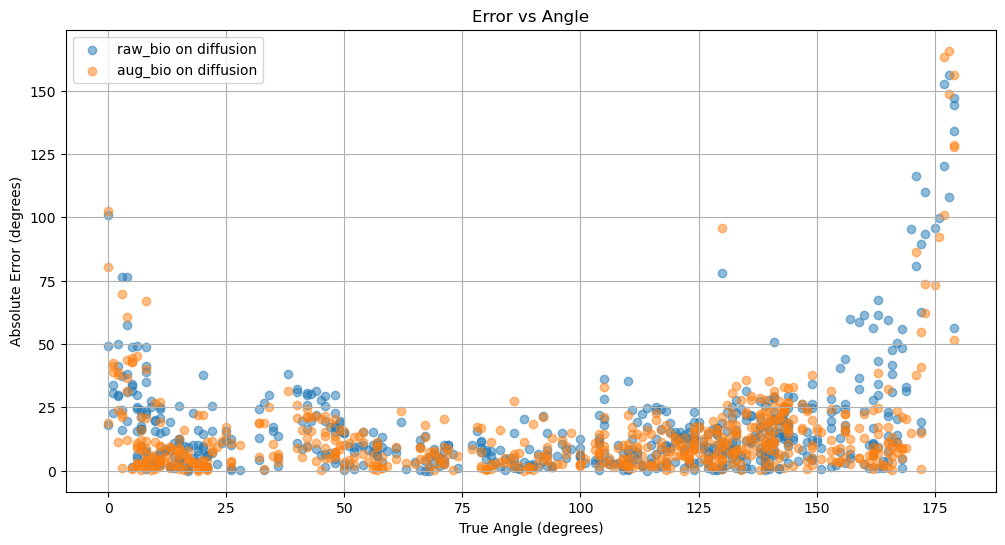

In [8]:
def plot_error_vs_angle(results):
    """Plot error magnitude vs true angle"""
    test_sets = [key for key in results[0].keys() if key.endswith('_true')]
    
    plt.figure(figsize=(12, 6))
    
    for result in results:
        for test_set in test_sets:
            set_name = test_set[:-5]  # Remove '_true'
            true_vals = result[f'{set_name}_true']
            errors = np.abs(result[f'{set_name}_pred'] - true_vals)
            
            plt.scatter(true_vals, errors, alpha=0.5,
                       label=f'{result["model_name"]} on {set_name}')
    
    plt.xlabel('True Angle (degrees)')
    plt.ylabel('Absolute Error (degrees)')
    plt.title('Error vs Angle')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot error vs angle
plot_error_vs_angle(results)